![STSCI banner](https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png)

# How to read posterior distributions

**Author**: Néstor Espinoza (Assistant Astronomer; Mission Scientist for Exoplanet Science) <br>
**Last Updated**: Aug 10, 2023<br>

## 1.<font color='white'>-</font>Reading the data <a class="anchor" id="intro"></a>

Let's read the data. We first load the `pickle` library:

In [1]:
import pickle

Let's read one of the posteriors in `/ifs/jwst/wit/niriss/kevin/test_ray_linearity/test4/fwd_cpkl_one`, taken at random:

In [2]:
chain = pickle.load(open('/ifs/jwst/wit/niriss/kevin/test_ray_linearity/test4/fwd_cpkl_one/forchain_meanlong_38_73.cpkl', 'rb'))

I'm guessing this is the MCMC chain corresponding to pixel (38, 73). According to the script, this is a dictionary; let's check its keys:

In [4]:
chain.keys()

dict_keys(['chain', 'burnin', 'nwalkers', 'niter'])

This dictionary hosts in the `chain` key, the actual MCMC chain. The rest of the elements define the number of burn-in samples `burnin` (samples used to make the chain converge around the posterior distribution), the number of walkers of `emcee` (`nwalkers`), which are the ones that wander around the posterior, and `niter`, the number of **total** iterations of the algorithm (i.e., the number of chains in the MCMC). 

Let's print the last three numbers: 

In [12]:
print('Number of burnin iterations:', chain['burnin'])
print('Number of walkers:', chain['nwalkers'])
print('Number of iterations:', chain['niter'])

Number of burnin iterations: 600
Number of walkers: 50
Number of iterations: 1200


What this is telling us is that the total number of chains was 1200, but 600 of those 1200 iterations were used as `burnin` and "discarded" from the chain. 

Ensemble samplers like `emcee` make in this case 50 walkers wander around over `niter` iterations --- and once they are sampling from the posterior, all can be thought of as providing samples from the posterior. This implies the output chain should have a total of (50) x (600) = 30,000 samples. Indeed:

In [13]:
chain['chain'].shape

(30000, 5)

has dimensions `(nsamples, ndim)`, where `nsamples` is the number of samples from the posterior and `ndim` is the number of dimensions (here, coefficients being fitted). This `chain` key is actually a dataframe, so we can easy visualize its contents by printing it: 

In [18]:
chain['chain']

,S,C0,C1,C2,C3
0,36.711600,-0.000005,1.667248e-10,-3.711209e-15,2.658735e-20
1,35.808585,-0.000001,-4.909619e-12,-6.847669e-16,8.020527e-21
2,35.914033,-0.000002,1.318256e-11,-8.138003e-16,7.252208e-21
3,36.399795,-0.000004,9.161228e-11,-2.238250e-15,1.660451e-20
4,36.467747,-0.000003,7.291903e-11,-1.912508e-15,1.467122e-20
...,...,...,...,...,...
29995,36.250244,-0.000003,7.626815e-11,-2.009033e-15,1.534908e-20
29996,36.415562,-0.000004,9.930006e-11,-2.368496e-15,1.731571e-20
29997,36.201180,-0.000003,8.227875e-11,-2.223546e-15,1.714867e-20
29998,35.963681,-0.000003,5.636739e-11,-1.843894e-15,1.539234e-20


So, first element of the chain `S` is likely the slope. Let's explore how this chain behaves:

In [19]:
import matplotlib.pyplot as plt

(array([35.25, 35.5 , 35.75, 36.  , 36.25, 36.5 , 36.75, 37.  , 37.25]),
 [Text(0, 35.25, '35.25'),
  Text(0, 35.5, '35.50'),
  Text(0, 35.75, '35.75'),
  Text(0, 36.0, '36.00'),
  Text(0, 36.25, '36.25'),
  Text(0, 36.5, '36.50'),
  Text(0, 36.75, '36.75'),
  Text(0, 37.0, '37.00'),
  Text(0, 37.25, '37.25')])

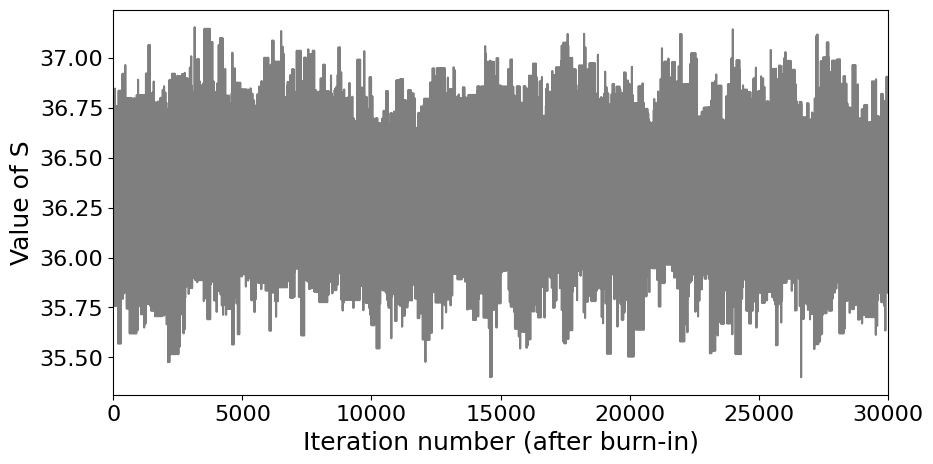

In [25]:
plt.figure(figsize=(10,5))

plt.plot(chain['chain']['S'].values, color = 'black', alpha = 0.5)
plt.xlim(0, 30000)

plt.xlabel('Iteration number (after burn-in)', fontsize = 18)
plt.ylabel('Value of S', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

That looks pretty stable, which is good! This shape suggests we can essentially treat each column above as samples from the posterior distribution. We can plot the joint posterior distribution of, say, `S` and `C0` as follows:

(array([-8.e-06, -7.e-06, -6.e-06, -5.e-06, -4.e-06, -3.e-06, -2.e-06,
        -1.e-06,  0.e+00,  1.e-06,  2.e-06]),
 [Text(0, -8e-06, '−8'),
  Text(0, -7e-06, '−7'),
  Text(0, -6e-06, '−6'),
  Text(0, -4.9999999999999996e-06, '−5'),
  Text(0, -4e-06, '−4'),
  Text(0, -3e-06, '−3'),
  Text(0, -1.9999999999999995e-06, '−2'),
  Text(0, -9.999999999999997e-07, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0000000000000006e-06, '1'),
  Text(0, 1.9999999999999995e-06, '2')])

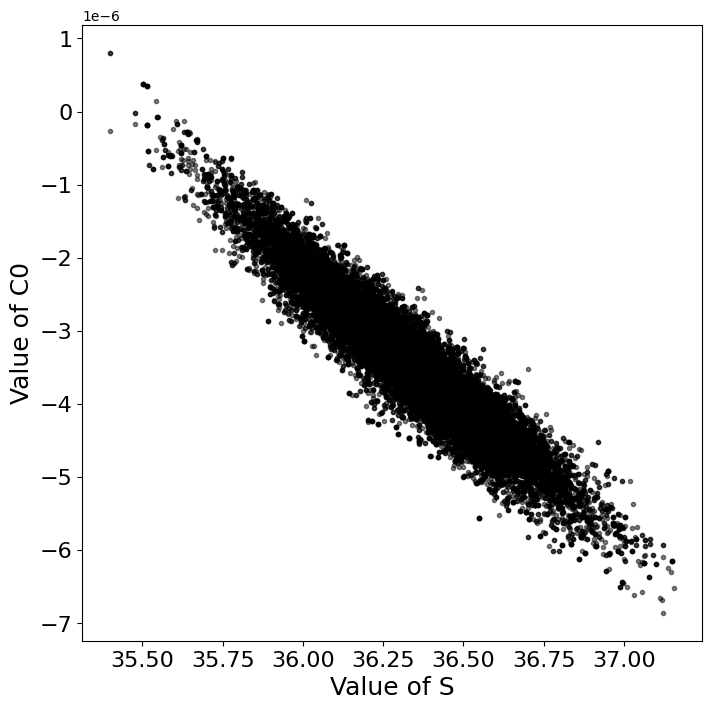

In [31]:
plt.figure(figsize=(8,8))

plt.plot(chain['chain']['S'].values, chain['chain']['C0'].values, '.', color = 'black', alpha = 0.5)

plt.xlabel('Value of S', fontsize = 18)
plt.ylabel('Value of C0', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

Indeed --- very co-variant! So, we can transform this dataframe to a simple numpy array as follows:

In [32]:
posterior_samples = chain['chain'].values

With this, each **row** of this array will have coefficients that form a solution from the MCMC chain. For instance, this is a solution of the MCMC chain for the 5 coefficients:

In [37]:
posterior_samples[0,:]

array([ 3.67115998e+01, -5.15724693e-06,  1.66724836e-10, -3.71120893e-15,
        2.65873485e-20])

This is another:

In [38]:
posterior_samples[1,:]

array([ 3.58085850e+01, -1.47004896e-06, -4.90961880e-12, -6.84766939e-16,
        8.02052723e-21])

And so on. If we created a function `f(coefficients)`, for instance, that took those coefficients and created a model with those (say, a polynomial), then we could plot all those solutions in a plot as follows:

In [39]:
for i in range(posterior_samples.shape[0]):

    plt.plot( f(posterior_samples[i, :]), alpha = 0.01, color = 'black' ) 

29999
